In [2]:
import unicodedata
import string
import re
import time
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import pickle

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def convert_to_pickle(item, directory):
    """import data
    """
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    """load data
    """
    return pickle.load(open(directory,"rb"))

In [4]:
data = pd.read_csv('./data/allData.csv',lineterminator='\n',encoding='utf-8')

In [5]:
data.head()

,ID,review,label\r
0,1,story of a man who has unnatural feelings for ...,Negative\r
1,2,airport starts as a brand new luxury plane is ...,Negative\r
2,3,this film lacked something i couldnt put my fi...,Negative\r
3,4,sorry everyone i know this is supposed to be a...,Negative\r
4,5,when i was little my parents took me along to ...,Negative\r


## Data preprocessing

Data preprocessing can be roughly divided into the following parts.

1. Convert all letters to Ascii

2. Convert all uppercase to lowercase; At the same time, keep only common punctuation marks

3. Create word2idx, idx2word, word2count(the number of times each word appears), n_word(the total number of words).

4. Convert these sentences into Tensor and use index for each word

5. Fill the sentences so that each sentence is the same length, so that you can use batch for training

6. Convert the label to one-hot format for the convenience of the final training (in Pytorch, it only needs to be converted to label)

 

### Creating word2index and index2word

In [6]:
# Data preprocess 1
def unicodeToAscii(s):
    """change to Ascii
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Data preprocess 2
def normalizeString(s):
    """change to lower case and remove punctuation
    """
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = unicodeToAscii(s.lower().strip())
    return s

# Data preprocess 3
class Lang():
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:"SOS",1:"EOS"}
        self.n_words = 2
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words 
            self.word2count[word] = 1 
            self.index2word[self.n_words] = word
            self.n_words = self.n_words + 1
        else:
            self.word2count[word] = self.word2count[word] + 1


In [7]:
lang = Lang()
for sentence_data in data["review"].values.tolist():
    sentence_data = normalizeString(sentence_data)
    lang.addSentence(sentence_data)

print("Count word:{}".format(lang.n_words))

Count word:130331


In [8]:
data_count = np.array(list(lang.word2count.values()))

np.median(data_count), np.mean(data_count), np.max(data_count) 

(2.0, 87.84213030100744, 665645)

In [9]:
less_count = 0
total_count = 0

for _,count in lang.word2count.items():
    if count < 50:
        less_count = less_count + count
    total_count = total_count + count

In [10]:
# We set word need to be appear 50 times to be counted
lang_process = Lang()

for word,count in lang.word2count.items():
    if count >= 50:
        lang_process.word2index[word] = lang_process.n_words 
        lang_process.word2count[word] = count
        lang_process.index2word[lang_process.n_words] = word
        lang_process.n_words = lang_process.n_words + 1
        
print("Count word:{}".format(lang_process.n_words))

Count word:11102


In [11]:
lang_process.word2count

{'story': 22899,
 'of': 289290,
 'a': 321814,
 'man': 11057,
 'who': 40338,
 'has': 32979,
 'unnatural': 97,
 'feelings': 796,
 'for': 87263,
 'pig': 162,
 'starts': 2298,
 'out': 34095,
 'with': 87164,
 'opening': 1985,
 'scene': 10876,
 'that': 136735,
 'is': 210700,
 'terrific': 829,
 'example': 2664,
 'absurd': 551,
 'comedy': 6500,
 'formal': 53,
 'orchestra': 115,
 'audience': 4209,
 'turned': 1862,
 'into': 17834,
 'an': 42916,
 'insane': 509,
 'violent': 1010,
 'mob': 351,
 'by': 44422,
 'the': 665645,
 'crazy': 1262,
 'its': 49085,
 'singers': 156,
 'unfortunately': 2590,
 'it': 155572,
 'stays': 334,
 'whole': 6116,
 'time': 24901,
 'no': 25073,
 'general': 1490,
 'narrative': 818,
 'eventually': 1404,
 'making': 5760,
 'just': 34986,
 'too': 15273,
 'off': 12003,
 'putting': 722,
 'even': 24715,
 'those': 9367,
 'from': 40429,
 'era': 1161,
 'should': 9615,
 'be': 53328,
 'dialogue': 3053,
 'would': 24213,
 'make': 15871,
 'shakespeare': 454,
 'seem': 4222,
 'easy': 1583,
 '

### Convert text to Tensor
-Convert text to Tensor(Before you need to tensor, you need to normalise the words)

In [12]:
# Take the sentences in the data and convert them into tensor in order

# The words in the sentence also need to be standardized when is converted here
def convertWord2index(word):
    if lang_process.word2index.get(word)==None:
        # some word appear only a few times are set to 1
        return 1
    else:
        return lang_process.word2index.get(word)
    
input_tensor = [[convertWord2index(s) for s in normalizeString(es).split(' ')]  for es in data["review"].values.tolist()]

In [13]:
# Look at the last two sentences
input_tensor[-2:]

[[180,
  463,
  14,
  601,
  35,
  5603,
  80,
  3837,
  1176,
  10,
  213,
  3,
  33,
  404,
  278,
  3018,
  163,
  207,
  194,
  208,
  930,
  83,
  33,
  972,
  38,
  5800,
  248,
  3546,
  4954,
  80,
  421,
  1584,
  51,
  9189,
  122,
  33,
  342,
  4909,
  787,
  107,
  35,
  589,
  7642,
  14,
  35,
  888,
  4505,
  80,
  2938,
  107,
  35,
  545,
  6449,
  1,
  33,
  163,
  2,
  3,
  33,
  685,
  2116,
  910,
  32,
  4,
  2304,
  3,
  163,
  2963,
  1,
  1,
  203,
  6757,
  63,
  2329,
  307,
  3,
  33,
  463,
  194,
  1558,
  1036,
  27,
  197,
  3719,
  351,
  69,
  63,
  196,
  17,
  180,
  463,
  18,
  7483,
  107,
  80,
  3,
  1492,
  38,
  120,
  358,
  107,
  442,
  38,
  782,
  80,
  782,
  38,
  440,
  38,
  995,
  33,
  404,
  2406,
  6443,
  3,
  528,
  601,
  3,
  373,
  82,
  56,
  3510,
  32,
  33,
  2280,
  404,
  2964,
  628,
  2388,
  9851,
  180,
  463,
  3,
  35,
  871,
  1,
  7,
  1454,
  107,
  460,
  33,
  685,
  9,
  33,
  1204,
  852,
  2183,
  1,
  57

In [14]:
data["review"].values.tolist()[-2:]

['this movie with all its complexity and subtlety makes for one of the most thought provoking short films i have ever seen the topics it addresses are ugly cynical and at times even macabre but the film remains beautiful in its language artful with its camera angles and gorgeous in its style skillfully recreating the short story of the same name written by a master of short stories tobias wolff not wishing to spoil anything of the movie i wont go into any details other than to say that this movie is magnificent in and of itself it takes pride in what it does and does it well it shows the most important memories of life all of which can be topped by the single most elusive feeling unexpected bliss this movie of its own volition has created in me the same feelings the main character tom noonan felt when words transformed his very existence and that is one impressive feat',
 'ive seen this story before but my kids havent boy with troubled past joins military faces his past falls in love a

In [15]:
#  This index corresponds to word (you can see that it is case insensitive - this is important)
lang_process.index2word[192]

'like'

### Word Padding

- Convert Tensor into Tensor of fixed length, take away the superfluous ones and replace them with zero

In [16]:

#  Check the average/mediam/maximam length of the sentences
sentence_length = [len(t) for t in input_tensor]
print(np.mean(sentence_length))
print(np.median(sentence_length))
print(np.max(sentence_length))

228.96754
172.0
2462


C:\Users\Austin\AppData\Local\Temp\ipykernel_3080\3599462440.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


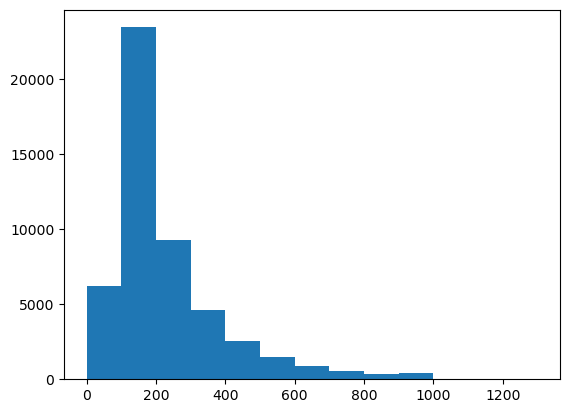

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bins = np.arange(0,1400,100) # Generating interval scale

ax.hist(sentence_length,bins=bins)
fig.show()

C:\Users\Austin\AppData\Local\Temp\ipykernel_3080\1315754175.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


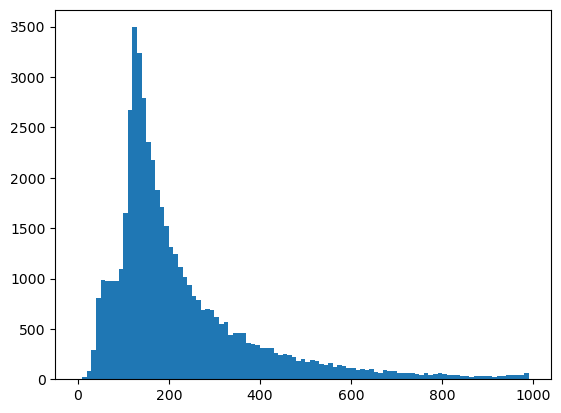

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
bins = np.arange(0,1000,10) # Generating interval scale

ax.hist(sentence_length,bins=bins)
fig.show()

From the image above, we can see that a sentence length of 1000 is a good value.
This means that sentences longer than 1000 words are removed from the end of the section (cut-off), and sentences less than 1000 words are added to the end of the 0.

In [19]:

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: 
        padded[:] = x[:max_len]
    else: 
        padded[:len(x)] = x
    return padded

In [20]:
input_tensor = [pad_sequences(x, 1000) for x in input_tensor]

In [21]:
# Take a look at the data after the population is complete

input_tensor[-2:]

[array([ 180,  463,   14,  601,   35, 5603,   80, 3837, 1176,   10,  213,
           3,   33,  404,  278, 3018,  163,  207,  194,  208,  930,   83,
          33,  972,   38, 5800,  248, 3546, 4954,   80,  421, 1584,   51,
        9189,  122,   33,  342, 4909,  787,  107,   35,  589, 7642,   14,
          35,  888, 4505,   80, 2938,  107,   35,  545, 6449,    1,   33,
         163,    2,    3,   33,  685, 2116,  910,   32,    4, 2304,    3,
         163, 2963,    1,    1,  203, 6757,   63, 2329,  307,    3,   33,
         463,  194, 1558, 1036,   27,  197, 3719,  351,   69,   63,  196,
          17,  180,  463,   18, 7483,  107,   80,    3, 1492,   38,  120,
         358,  107,  442,   38,  782,   80,  782,   38,  440,   38,  995,
          33,  404, 2406, 6443,    3,  528,  601,    3,  373,   82,   56,
        3510,   32,   33, 2280,  404, 2964,  628, 2388, 9851,  180,  463,
           3,   35,  871,    1,    7, 1454,  107,  460,   33,  685,    9,
          33, 1204,  852, 2183,    1, 

### tranfer the label to the one hot 

In [22]:
# Look at all the categories


data['label\r'].unique()

array(['Negative\r', 'Positive\r'], dtype=object)

In [23]:
index2emotion = {0: 'Negative\r', 1: 'Positive\r'}
emotion2index = {'Negative\r' : 0, 'Positive\r' : 1}
target_tensor = [emotion2index.get(s) for s in data['label\r'].values.tolist()]

In [24]:
# Take a quick look at the sample


target_tensor[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
target_tensor[10:]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [26]:
# convert_to_pickle(input_tensor, './data/input_tensor.pkl')
# convert_to_pickle(target_tensor, './data/target_tensor.pkl')

At this point, the pre-processing of the Data set is all done. The next step is to create the Data Loader, which can be used to finally put into the entire model.

## Data Loader

- Partitioning of data sets, training sets and test sets
- Data set loading, using DataLoader to load the data set

In [27]:
# Division of data sets (half part is training set and remain half part is test set)
END = int(len(input_tensor)*0.5)

input_tensor_train = torch.from_numpy(np.array(input_tensor[:END]))
target_tensor_train = torch.from_numpy(np.array(target_tensor[:END])).long()

input_tensor_test = torch.from_numpy(np.array(input_tensor[END:]))
target_tensor_test = torch.from_numpy(np.array(target_tensor[END:])).long()

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_test), len(target_tensor_test)

(25000, 25000, 25000, 25000)

In [28]:
# test_loader = load_from_pickle('./data/test_loader.pkl')

In [29]:
#for i,j in test_loader:
 #   print(i.shape,j.shape)

In [30]:
# dataloader
train_dataset = Data.TensorDataset(input_tensor_train, target_tensor_train) 
test_dataset = Data.TensorDataset(input_tensor_test, target_tensor_test) 

MINIBATCH_SIZE = 64

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2           # set multi-work num read data
)


In [31]:
# convert_to_pickle(train_loader, './data/train_loader.pkl')
# convert_to_pickle(test_loader, './data/test_loader.pkl')

At this point, you've created your dataload, and you're ready to start building your network and training

## Creating Models

### Creating Simple RNN Model

In [57]:
# Simple RNN
class EmotionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmotionRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_units, batch_first = True)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        assert torch.equal(output[:, -1, :], hidden.squeeze(0))
        output = self.fc(output[:,-1,:])
        output = F.log_softmax(output, dim=1)
        return output

In [58]:
# Test model
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 

model = EmotionRNN(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size).to(device)

# Test data
it = iter(train_loader)
x, y = next(it)

output = model(x.to(device))

In [59]:
print(y.shape)
print(output.size())

torch.Size([64])
torch.Size([64, 2])


In [60]:
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (logit == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [61]:
accuracy(output,y.to(device))

tensor(46.8750, device='cuda:0')

In [62]:
y

tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [63]:
torch.max(output, 1)[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

### Creating Bi-directional GRU Model

In [39]:
# Bi-GRU
class EmotionGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionGRU, self).__init__()
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim) 
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)
        
    def init_hidden(self):
        # Using bidirectional RNN, so num_layer = num_layer*2
        return torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        self.hidden = self.init_hidden()
        output, self.hidden = self.gru(x, self.hidden)
        # print(output.shape)
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        # output = F.log_softmax(output, dim=1)
        return output

In [40]:
# Test model
vocab_inp_size = len(lang_process.word2index)
embedding_dim = 256
hidden_units = 512
target_size = 2 
layers = 3

model = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)

# Test data
it = iter(train_loader)
x, y = next(it)

output = model(x.to(device))

In [41]:
y.shape

torch.Size([64])

In [42]:
# 64*2, we have 64 samples, every sample is the probablity if the  2 emotion
output.size()

torch.Size([64, 2])

In [43]:
accuracy(output,y.to(device))

tensor(42.1875, device='cuda:0')

In [44]:
y

tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

In [45]:
torch.max(output, 1)[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

###  Creating the Bi-directional LSTM Model

In [46]:
# Bi-LSTM
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size, layers=2):
        super(EmotionLSTM, self).__init__()
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.batch_sz = batch_sz
        self.output_size = output_size
        self.num_layers = layers
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(0.5)
        self.gru = nn.LSTM(self.embedding_dim, self.hidden_units, num_layers=self.num_layers, batch_first = True, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(self.hidden_units*2, self.output_size)

    def init_hidden(self):
        return (torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device),
               torch.zeros((self.num_layers*2, self.batch_sz, self.hidden_units)).to(device))
    
    def forward(self,x):
        self.batch_sz = x.size(0)
        # print(x.shape)
        x = self.embedding(x)
        # print(x.shape)
        (self.hidden, self.cell_state) = self.init_hidden()
        output, (self.hidden, self.cell_state) = self.gru(x, (self.hidden, self.cell_state))
        # print(output.shape)
        output = output[:,-1,:]
        output = self.dropout(output)
        output = self.fc(output)
        # print(output.shape)
        # output = F.log_softmax(output, dim=1)
        return output

In [47]:
# tesing model
vocab_inp_size = len(lang_process.word2index) + 2
embedding_dim = 256
hidden_units = 512
target_size = 2 # 2  emotion
layers = 3

# tesing model
model = EmotionLSTM(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)

# testing data
it = iter(train_loader)
x, y = next(it)

output = model(x.to(device))

In [48]:
accuracy(output,y.to(device))

tensor(35.9375, device='cuda:0')

In [49]:
y

tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1])

In [50]:
torch.max(output, 1)[1]

tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [51]:
def epoch_time(start, end):
    time = end - start
    mins = int(time / 60)
    secs = int(time - (mins * 60))
    
    return mins, secs

## Training for LSTM

- Define the loss function

- Define the optimizer

In [53]:
# Model hyperparameter
vocab_inp_size = len(lang_process.word2index) + 2
embedding_dim = 256
hidden_units = 512
target_size = 2
num_layers = [2]

for layers in num_layers:
    # Test model
    modelLSTM = EmotionLSTM(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    models = {}
    
    models['LSTM'] = modelLSTM
    # models['GRU'] = modelGRU
    for key, model in models.items():
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),lr=0.001)

        # Start training
        num_epochs = 50
        for epoch in range(num_epochs):
            model.train()
            start = time.time()

            train_total_loss = 0 # Record the average loss in an entire epoch
            train_total_accuracy = 0 # Record the average accuracy in an entire epoch

            ### Training
            for batch, (inp, targ) in enumerate(train_loader):
                predictions = model(inp.to(device))
                # Error in calculation   
                loss = criterion(predictions, targ.to(device))
                # Reverse propagation to modify the weight
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Record Loss decreases and accuracy improves
                batch_loss = (loss / int(targ.size(0))) # Record a bacth loss
                batch_accuracy = accuracy(predictions, targ.to(device))

                train_total_loss = train_total_loss + batch_loss
                train_total_accuracy = train_total_accuracy + batch_accuracy

                if batch % 100 == 0:
                    record_train_accuracy = train_total_accuracy.cpu().detach().numpy()/(batch+1)
                    print('Layer {} Epoch {} Batch {} Accuracy {:.4f}. Loss {:.4f}'.format(layers, epoch + 1,
                                                                 batch,
                                                                 train_total_accuracy.cpu().detach().numpy()/(batch+1),
                                                                 train_total_loss.cpu().detach().numpy()/(batch+1)))
            # Each epoch is used to calculate the accuracy of the test
            print('------------')
            model.eval()
            test_total_accuracy = 0
            for batch, (input_data, target_data) in enumerate(test_loader):
                predictions1 = model(input_data.to(device))
                batch_accuracy1 = accuracy(predictions1, target_data.to(device))
                test_total_accuracy = test_total_accuracy + batch_accuracy1
            print('Test : Lay {}, Model {}, Epoch {} Accuracy {:.4f}'.format(layers, key, epoch + 1, test_total_accuracy.cpu().detach().numpy()/(batch+1)))
            record_test_accuracy = test_total_accuracy.cpu().detach().numpy()/(batch+1)
            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            print('Epoch time : {}mins {}secs'.format(epoch_mins, epoch_secs))
            if epoch == num_epochs - 1:
                # Write the results of the last round to the file
                with open('byr.txt','a') as file:
                    file.write('{},{},{:.4f},{:.4f}'.format(key,layers,record_train_accuracy,record_test_accuracy))
            print('============')

Layer 2 Epoch 1 Batch 0 Accuracy 53.1250. Loss 0.0109
Layer 2 Epoch 1 Batch 100 Accuracy 49.5823. Loss 0.0109
Layer 2 Epoch 1 Batch 200 Accuracy 49.3004. Loss 0.0109
Layer 2 Epoch 1 Batch 300 Accuracy 49.8443. Loss 0.0109
------------
Test : Lay 2, Model LSTM, Epoch 1 Accuracy 50.0304
Epoch time : 2mins 37secs
Layer 2 Epoch 2 Batch 0 Accuracy 50.0000. Loss 0.0109
Layer 2 Epoch 2 Batch 100 Accuracy 50.1083. Loss 0.0108
Layer 2 Epoch 2 Batch 200 Accuracy 50.3809. Loss 0.0108
Layer 2 Epoch 2 Batch 300 Accuracy 50.0363. Loss 0.0108
------------
Test : Lay 2, Model LSTM, Epoch 2 Accuracy 50.0184
Epoch time : 2mins 37secs
Layer 2 Epoch 3 Batch 0 Accuracy 48.4375. Loss 0.0108
Layer 2 Epoch 3 Batch 100 Accuracy 49.0563. Loss 0.0108
Layer 2 Epoch 3 Batch 200 Accuracy 49.4092. Loss 0.0108
Layer 2 Epoch 3 Batch 300 Accuracy 49.6107. Loss 0.0108
------------
Test : Lay 2, Model LSTM, Epoch 3 Accuracy 49.9896
Epoch time : 2mins 35secs
Layer 2 Epoch 4 Batch 0 Accuracy 54.6875. Loss 0.0108
Layer 2 Ep

Layer 2 Epoch 26 Batch 0 Accuracy 98.4375. Loss 0.0016
Layer 2 Epoch 26 Batch 100 Accuracy 94.4152. Loss 0.0030
Layer 2 Epoch 26 Batch 200 Accuracy 92.6928. Loss 0.0035
Layer 2 Epoch 26 Batch 300 Accuracy 92.7014. Loss 0.0035
------------
Test : Lay 2, Model LSTM, Epoch 26 Accuracy 84.9433
Epoch time : 2mins 36secs
Layer 2 Epoch 27 Batch 0 Accuracy 95.3125. Loss 0.0025
Layer 2 Epoch 27 Batch 100 Accuracy 94.4616. Loss 0.0028
Layer 2 Epoch 27 Batch 200 Accuracy 94.4419. Loss 0.0028
Layer 2 Epoch 27 Batch 300 Accuracy 94.5235. Loss 0.0028
------------
Test : Lay 2, Model LSTM, Epoch 27 Accuracy 85.2502
Epoch time : 2mins 36secs
Layer 2 Epoch 28 Batch 0 Accuracy 98.4375. Loss 0.0012
Layer 2 Epoch 28 Batch 100 Accuracy 95.5136. Loss 0.0024
Layer 2 Epoch 28 Batch 200 Accuracy 95.5924. Loss 0.0024
Layer 2 Epoch 28 Batch 300 Accuracy 95.6188. Loss 0.0023
------------
Test : Lay 2, Model LSTM, Epoch 28 Accuracy 85.0416
Epoch time : 2mins 35secs
Layer 2 Epoch 29 Batch 0 Accuracy 96.8750. Loss 0

## Training for GRU

- Define the loss function

- Define the optimizer

In [65]:
vocab_inp_size = len(lang_process.word2index) + 2
embedding_dim = 256
hidden_units = 512
target_size = 2 
num_layers = [2]

for layers in num_layers:
    modelGRU = EmotionGRU(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size, layers).to(device)
    models = {}
    
    models['GRU'] = modelGRU
    for key, model in models.items():
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(),lr=0.001)

        num_epochs = 30
        for epoch in range(num_epochs):
            model.train()
            start = time.time()

            train_total_loss = 0 
            train_total_accuracy = 0 

            for batch, (inp, targ) in enumerate(train_loader):
                predictions = model(inp.to(device))  
                loss = criterion(predictions, targ.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = (loss / int(targ.size(0)))  
                batch_accuracy = accuracy(predictions, targ.to(device))

                train_total_loss = train_total_loss + batch_loss
                train_total_accuracy = train_total_accuracy + batch_accuracy

                if batch % 100 == 0:
                    record_train_accuracy = train_total_accuracy.cpu().detach().numpy()/(batch+1)
                    print('Epoch {} Batch {} Accuracy {:.4f}. Loss {:.4f}'.format(epoch + 1,
                                                                 batch,
                                                                 train_total_accuracy.cpu().detach().numpy()/(batch+1),
                                                                 train_total_loss.cpu().detach().numpy()/(batch+1)))
            
            print('------------')
            model.eval()
            test_total_accuracy = 0
            for batch, (input_data, target_data) in enumerate(test_loader):
                predictions = model(input_data.to(device))
                batch_accuracy = accuracy(predictions, target_data.to(device))
                test_total_accuracy = test_total_accuracy + batch_accuracy
            print('Test : Lay {}, Model {}, Epoch {} Accuracy {:.4f}'.format(layers, key, epoch + 1, test_total_accuracy.cpu().detach().numpy()/(batch+1)))
            record_test_accuracy = test_total_accuracy.cpu().detach().numpy()/(batch+1)
            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            print('Epoch time : {}mins {}secs'.format(epoch_mins, epoch_secs))
            if epoch == num_epochs - 1:
                with open('byr.txt','a') as file:
                    file.write('{},{},{:.4f},{:.4f}'.format(key,layers,record_train_accuracy,record_test_accuracy))
            print('============')


Epoch 1 Batch 0 Accuracy 53.1250. Loss 0.0106
Epoch 1 Batch 100 Accuracy 51.0675. Loss 0.0115
Epoch 1 Batch 200 Accuracy 54.3221. Loss 0.0111
Epoch 1 Batch 300 Accuracy 59.4892. Loss 0.0105
------------
Test : Lay 2, Model GRU, Epoch 1 Accuracy 81.8167
Epoch time : 2mins 54secs
Epoch 2 Batch 0 Accuracy 89.0625. Loss 0.0049
Epoch 2 Batch 100 Accuracy 83.4468. Loss 0.0060
Epoch 2 Batch 200 Accuracy 85.1135. Loss 0.0055
Epoch 2 Batch 300 Accuracy 85.8544. Loss 0.0053
------------
Test : Lay 2, Model GRU, Epoch 2 Accuracy 87.4512
Epoch time : 2mins 53secs
Epoch 3 Batch 0 Accuracy 90.6250. Loss 0.0032
Epoch 3 Batch 100 Accuracy 92.8682. Loss 0.0031
Epoch 3 Batch 200 Accuracy 92.6073. Loss 0.0031
Epoch 3 Batch 300 Accuracy 92.5405. Loss 0.0031
------------
Test : Lay 2, Model GRU, Epoch 3 Accuracy 88.7396
Epoch time : 2mins 53secs
Epoch 4 Batch 0 Accuracy 92.1875. Loss 0.0031
Epoch 4 Batch 100 Accuracy 96.7976. Loss 0.0016
Epoch 4 Batch 200 Accuracy 96.5330. Loss 0.0017
Epoch 4 Batch 300 Acc

Test : Lay 2, Model GRU, Epoch 28 Accuracy 88.0195
Epoch time : 2mins 53secs
Epoch 29 Batch 0 Accuracy 100.0000. Loss 0.0001
Epoch 29 Batch 100 Accuracy 99.7525. Loss 0.0001
Epoch 29 Batch 200 Accuracy 99.7435. Loss 0.0001
Epoch 29 Batch 300 Accuracy 99.7664. Loss 0.0001
------------
Test : Lay 2, Model GRU, Epoch 29 Accuracy 87.6455
Epoch time : 2mins 56secs
Epoch 30 Batch 0 Accuracy 100.0000. Loss 0.0001
Epoch 30 Batch 100 Accuracy 99.7679. Loss 0.0001
Epoch 30 Batch 200 Accuracy 99.6580. Loss 0.0002
Epoch 30 Batch 300 Accuracy 99.6159. Loss 0.0002
------------
Test : Lay 2, Model GRU, Epoch 30 Accuracy 86.6081
Epoch time : 2mins 54secs


## Training for Simple RNN

- Define the loss function

- Define the optimizer

In [66]:
vocab_inp_size = len(lang_process.word2index)+2
embedding_dim = 256
hidden_units = 512
target_size = 2 
num_layers = [1]

for layers in num_layers:
    modelRNN = EmotionRNN(vocab_inp_size, embedding_dim, hidden_units, MINIBATCH_SIZE, target_size).to(device)
    models = {}
    
    models['RNN'] = modelRNN
    for key, model in models.items():
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(),lr=0.001)

        num_epochs = 30
        for epoch in range(num_epochs):
            model.train()
            start = time.time()

            train_total_loss = 0 
            train_total_accuracy = 0 

            ### Training
            for batch, (inp, targ) in enumerate(train_loader):
                predictions = model(inp.to(device))  
                loss = criterion(predictions, targ.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = (loss / int(targ.size(0)))   
                batch_accuracy = accuracy(predictions, targ.to(device))

                train_total_loss = train_total_loss + batch_loss
                train_total_accuracy = train_total_accuracy + batch_accuracy

                if batch % 100 == 0:
                    record_train_accuracy = train_total_accuracy.cpu().detach().numpy()/(batch+1)
                    print('Epoch {} Batch {} Accuracy {:.4f}. Loss {:.4f}'.format(epoch + 1,
                                                                 batch,
                                                                 train_total_accuracy.cpu().detach().numpy()/(batch+1),
                                                                 train_total_loss.cpu().detach().numpy()/(batch+1)))
            
            print('------------')
            model.eval()
            test_total_accuracy = 0
            for batch, (input_data, target_data) in enumerate(test_loader):
                predictions = model(input_data.to(device))
                batch_accuracy = accuracy(predictions, target_data.to(device))
                test_total_accuracy = test_total_accuracy + batch_accuracy
            print('Test : Model {}, Epoch {} Accuracy {:.4f}'.format(key, epoch + 1, test_total_accuracy.cpu().detach().numpy()/(batch+1)))
            record_test_accuracy = test_total_accuracy.cpu().detach().numpy()/(batch+1)
            end = time.time()
            epoch_mins, epoch_secs = epoch_time(start, end)
            print('Epoch time : {}mins {}secs'.format(epoch_mins, epoch_secs))
            if epoch == num_epochs - 1:
                with open('byr.txt','a') as file:
                    file.write('{},{},{:.4f},{:.4f}'.format(key,layers,record_train_accuracy,record_test_accuracy))
            print('============')


Epoch 1 Batch 0 Accuracy 37.5000. Loss 0.0127
Epoch 1 Batch 100 Accuracy 49.7679. Loss 0.0109
Epoch 1 Batch 200 Accuracy 50.3654. Loss 0.0109
Epoch 1 Batch 300 Accuracy 50.3426. Loss 0.0108
------------
Test : Model RNN, Epoch 1 Accuracy 49.9544
Epoch time : 0mins 45secs
Epoch 2 Batch 0 Accuracy 40.6250. Loss 0.0108
Epoch 2 Batch 100 Accuracy 48.9790. Loss 0.0108
Epoch 2 Batch 200 Accuracy 48.8495. Loss 0.0108
Epoch 2 Batch 300 Accuracy 49.2577. Loss 0.0108
------------
Test : Model RNN, Epoch 2 Accuracy 49.9536
Epoch time : 0mins 45secs
Epoch 3 Batch 0 Accuracy 50.0000. Loss 0.0108
Epoch 3 Batch 100 Accuracy 49.2420. Loss 0.0108
Epoch 3 Batch 200 Accuracy 49.5569. Loss 0.0108
Epoch 3 Batch 300 Accuracy 49.7301. Loss 0.0108
------------
Test : Model RNN, Epoch 3 Accuracy 50.0296
Epoch time : 0mins 45secs
Epoch 4 Batch 0 Accuracy 48.4375. Loss 0.0108
Epoch 4 Batch 100 Accuracy 50.0464. Loss 0.0108
Epoch 4 Batch 200 Accuracy 49.3004. Loss 0.0108
Epoch 4 Batch 300 Accuracy 49.0449. Loss 0

Epoch 29 Batch 300 Accuracy 49.6937. Loss 0.0108
------------
Test : Model RNN, Epoch 29 Accuracy 50.0104
Epoch time : 0mins 45secs
Epoch 30 Batch 0 Accuracy 39.0625. Loss 0.0108
Epoch 30 Batch 100 Accuracy 49.8608. Loss 0.0108
Epoch 30 Batch 200 Accuracy 50.0389. Loss 0.0108
Epoch 30 Batch 300 Accuracy 50.0052. Loss 0.0108
------------
Test : Model RNN, Epoch 30 Accuracy 50.0144
Epoch time : 0mins 45secs
